In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix

# Path to ensemble prediction files (adjust if needed)
ensemble_folder ="/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12v3"
ensemble_avg_file = os.path.join(ensemble_folder, "ensemble_avg.csv")
ensemble_max_file = os.path.join(ensemble_folder, "ensemble_max.csv")

ensemble_avg = pd.read_csv(ensemble_avg_file)
ensemble_max = pd.read_csv(ensemble_max_file)


# Fixed thresholds from your ROC analysis:
threshold_avg = 0.20918673346079228    # Optimal threshold for LARS-avg (Youden's index)
threshold_max = 0.5062547015000001    # Optimal threshold for LARS-max (Youden's index)



In [2]:
# Identify individual model probability columns.
model_prob_cols = [col for col in ensemble_avg.columns if col.startswith("probs_model")]
n_models = len(model_prob_cols)
print("Found individual model probability columns:", model_prob_cols)

# Compute binary predictions using fixed thresholds:
for col in model_prob_cols:
    ensemble_avg[col.replace("probs", "pred")] = (ensemble_avg[col] >= threshold_avg).astype(int)
    ensemble_max[col.replace("probs", "pred")] = (ensemble_max[col] >= threshold_max).astype(int)

# Create lists for the binary prediction columns:
pred_cols_avg = [col.replace("probs", "pred") for col in model_prob_cols]
pred_cols_max = [col.replace("probs", "pred") for col in model_prob_cols]

# Also compute the vote_sum: number of models predicting positive per scan.
ensemble_avg['vote_sum'] = ensemble_avg[pred_cols_avg].sum(axis=1)
ensemble_max['vote_sum'] = ensemble_max[pred_cols_max].sum(axis=1)


Found individual model probability columns: ['probs_model0', 'probs_model1', 'probs_model2', 'probs_model3', 'probs_model4', 'probs_model5', 'probs_model6', 'probs_model7', 'probs_model8', 'probs_model9']


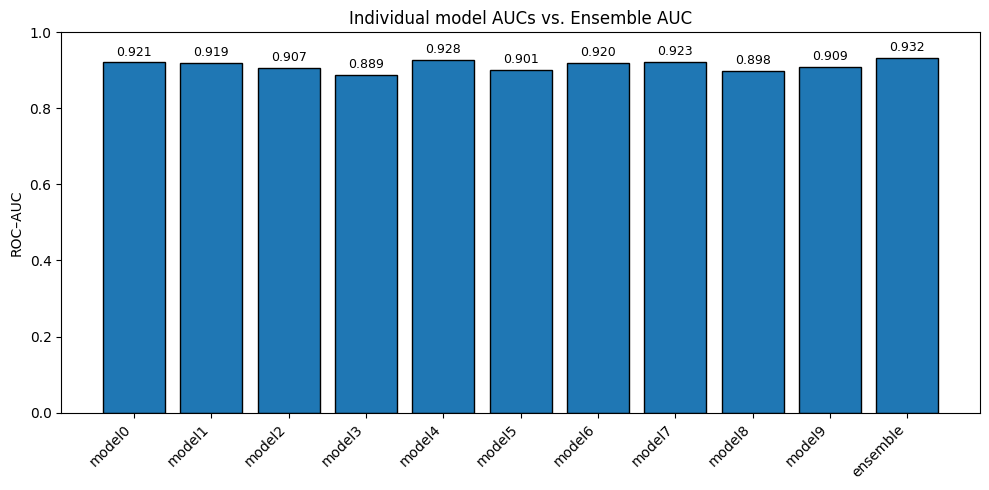

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 1. Compute AUCs
indiv_aucs = [
    roc_auc_score(ensemble_avg['target'], ensemble_avg[col])
    for col in model_prob_cols
]
labels = [col.replace("probs_", "") for col in model_prob_cols]

ensemble_auc = roc_auc_score(
    ensemble_avg['target'],
    ensemble_avg[model_prob_cols].mean(axis=1)
)
labels.append("ensemble")
all_aucs = indiv_aucs + [ensemble_auc]

# 2. Create bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(all_aucs)), all_aucs, edgecolor='k')
plt.xticks(range(len(all_aucs)), labels, rotation=45, ha='right')
plt.ylabel("ROC–AUC")
plt.ylim(0, 1)

# 3. Annotate raw values
for bar, auc in zip(bars, all_aucs):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.01, f"{auc:.3f}",
             ha='center', va='bottom', fontsize= 9)

plt.title("Individual model AUCs vs. Ensemble AUC")
plt.tight_layout()
plt.show()


In [19]:
def compute_agreement(df, pred_cols):
    # Count for each scan how many model predictions match the true label.
    correct_counts = np.zeros(len(df))
    for col in pred_cols:
        correct_counts += (df[col] == df['target']).astype(int)
    df['correct_count'] = correct_counts
    df['agreement_rate'] = df['correct_count'] / len(pred_cols)
    df['non_concordance'] = 1 - df['agreement_rate']
    return df

ensemble_avg = compute_agreement(ensemble_avg, pred_cols_avg)
ensemble_max = compute_agreement(ensemble_max, pred_cols_max)

print(f"[LARS-avg] Mean Agreement Rate: {ensemble_avg['agreement_rate'].mean():.3f}")
print(f"[LARS-avg] Mean Non-Concordance: {ensemble_avg['non_concordance'].mean():.3f}")


[LARS-avg] Mean Agreement Rate: 0.746
[LARS-avg] Mean Non-Concordance: 0.254


– A high agreement_rate means most individual models correctly predicted the scan’s label, regardless of what the ensemble prediction is.
– The non_concordance rate quantifies the level of disagreement with ground truth

In [20]:
# Compute standard deviation of continuous probabilities for each scan.
ensemble_avg['prob_std'] = ensemble_avg[model_prob_cols].std(axis=1)
ensemble_max['prob_std'] = ensemble_max[model_prob_cols].std(axis=1)

# Compute binary consistency: fraction of models in agreement with the majority vote.
ensemble_avg['binary_consistency'] = np.where(
    ensemble_avg['vote_sum'] >= n_models/2,
    ensemble_avg['vote_sum'] / n_models,
    (n_models - ensemble_avg['vote_sum']) / n_models
)
ensemble_max['binary_consistency'] = np.where(
    ensemble_max['vote_sum'] >= n_models/2,
    ensemble_max['vote_sum'] / n_models,
    (n_models - ensemble_max['vote_sum']) / n_models
)

print("[LARS-avg] Mean Probability Std: {:.3f}".format(ensemble_avg['prob_std'].mean()))
print("[LARS-avg] Mean Binary Consistency: {:.3f}".format(ensemble_avg['binary_consistency'].mean()))

print("[LARS-max] Mean Probability Std: {:.3f}".format(ensemble_max['prob_std'].mean()))
print("[LARS-max] Mean Binary Consistency: {:.3f}".format(ensemble_max['binary_consistency'].mean()))


[LARS-avg] Mean Probability Std: 0.161
[LARS-avg] Mean Binary Consistency: 0.834
[LARS-max] Mean Probability Std: 0.219
[LARS-max] Mean Binary Consistency: 0.853


In [21]:
# Define thresholds for high disagreement. For example, flag scans with binary_consistency < 0.6.
low_consistency_threshold = 0.6
disagreement_scans_avg = ensemble_avg[ensemble_avg['binary_consistency'] < low_consistency_threshold]
disagreement_scans_max = ensemble_max[ensemble_max['binary_consistency'] < low_consistency_threshold]

print(f"Number of scans with binary consistency < {low_consistency_threshold} (LARS-avg): {len(disagreement_scans_avg)}")
print("Scan IDs and metrics (LARS-avg):")
print(disagreement_scans_avg[['scan_id', 'vote_sum', 'binary_consistency', 'prob_std']])

# Optionally, you can also flag cases using the top quartile of prob_std.
high_std_threshold = ensemble_avg['prob_std'].quantile(0.75)
high_std_scans_avg = ensemble_avg[ensemble_avg['prob_std'] >= high_std_threshold]
print(f"\nNumber of scans with prob_std >= {high_std_threshold:.3f} (LARS-avg): {len(high_std_scans_avg)}")
print("Scan IDs and metrics (LARS-avg):")
print(high_std_scans_avg[['scan_id', 'vote_sum', 'binary_consistency', 'prob_std']])


Number of scans with binary consistency < 0.6 (LARS-avg): 13
Scan IDs and metrics (LARS-avg):
     scan_id  vote_sum  binary_consistency  prob_std
16      1329         5                 0.5  0.222018
48      1361         5                 0.5  0.328240
87      1400         5                 0.5  0.324208
129     1442         5                 0.5  0.254199
141     1454         5                 0.5  0.283083
146     1459         5                 0.5  0.287814
166     1479         5                 0.5  0.151952
197     1510         5                 0.5  0.232701
212     1525         5                 0.5  0.310471
249     1562         5                 0.5  0.324603
269     1582         5                 0.5  0.300901
271     1584         5                 0.5  0.230781
276     1589         5                 0.5  0.301096

Number of scans with prob_std >= 0.248 (LARS-avg): 73
Scan IDs and metrics (LARS-avg):
     scan_id  vote_sum  binary_consistency  prob_std
2       1315         3 

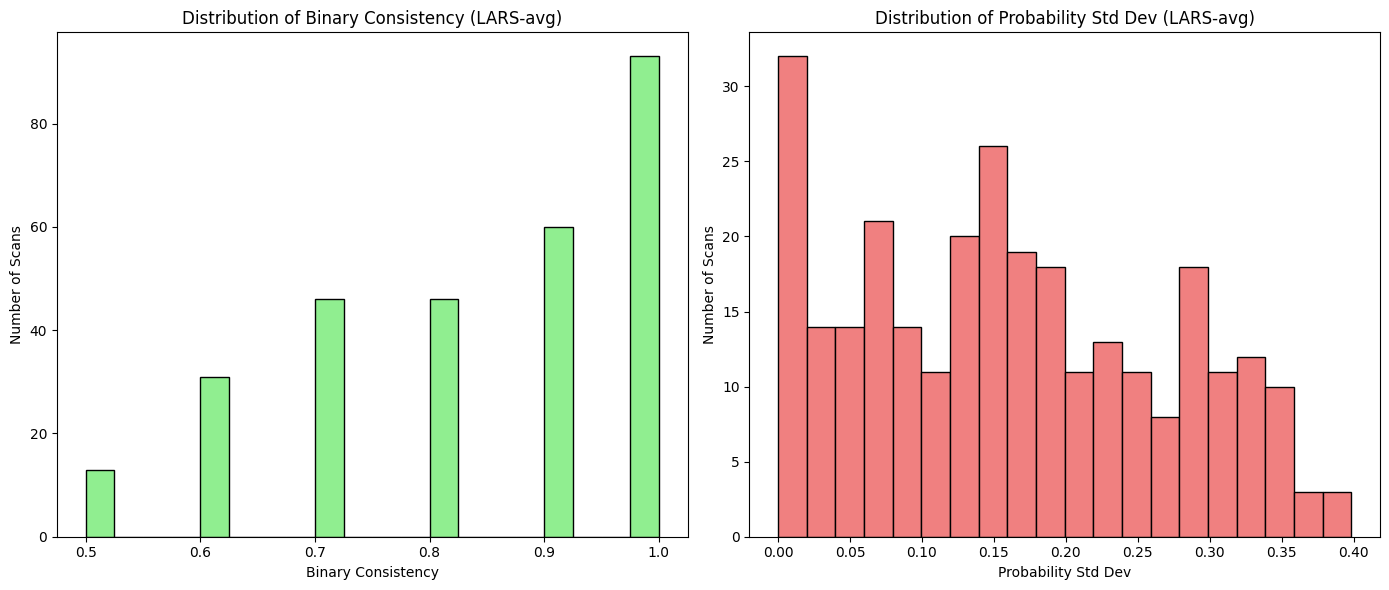

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(ensemble_avg['binary_consistency'], bins=20, color='lightgreen', edgecolor='k')
plt.xlabel("Binary Consistency")
plt.ylabel("Number of Scans")
plt.title("Distribution of Binary Consistency (LARS-avg)")

plt.subplot(1, 2, 2)
plt.hist(ensemble_avg['prob_std'], bins=20, color='lightcoral', edgecolor='k')
plt.xlabel("Probability Std Dev")
plt.ylabel("Number of Scans")
plt.title("Distribution of Probability Std Dev (LARS-avg)")

plt.tight_layout()
plt.show()


Performance for Ensemble Avg:
   ensemble_size  mean_auc  mean_acc
0              2  0.878780  0.740311
1              3  0.877708  0.787197
2              4  0.893099  0.777336
3              5  0.887224  0.801384
4              6  0.891297  0.791869
5              7  0.892232  0.791349
6              8  0.893699  0.789100
7              9  0.895293  0.791349
8             10  0.896344  0.782007
Performance for Ensemble Max:
   ensemble_size  mean_auc  mean_acc
0              2  0.884957  0.822145
1              3  0.881437  0.819896
2              4  0.892037  0.834429
3              5  0.888684  0.836159
4              6  0.890727  0.840138
5              7  0.892649  0.834256
6              8  0.892742  0.836332
7              9  0.896603  0.835640
8             10  0.898554  0.844291


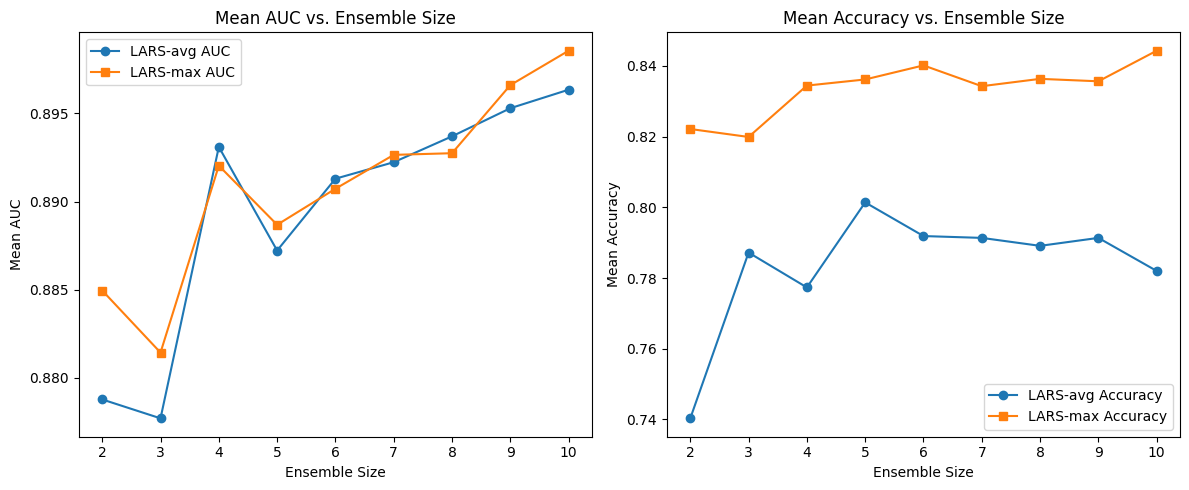

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate_subensemble(df, model_indices, threshold):
    # Use the median probability from the selected models as the subensemble prediction.
    cols = [f'probs_model{i}' for i in model_indices]
    subensemble_prob = df[cols].median(axis=1)
    pred_label = (subensemble_prob >= threshold).astype(int)
    auc = roc_auc_score(df['target'], subensemble_prob)
    acc = accuracy_score(df['target'], pred_label)
    return auc, acc

ensemble_size_range = range(2, n_models + 1)

# Evaluate for LARS-avg
ensemble_avg_performance = []
for size in ensemble_size_range:
    aucs, accs = [], []
    for combo in [np.random.choice(n_models, size, replace=False) for _ in range(20)]:
        auc, acc = evaluate_subensemble(ensemble_avg, combo, threshold_avg)
        aucs.append(auc)
        accs.append(acc)
    ensemble_avg_performance.append({
        'ensemble_size': size,
        'mean_auc': np.mean(aucs),
        'mean_acc': np.mean(accs)
    })
ensemble_avg_perf_df = pd.DataFrame(ensemble_avg_performance)
print("Performance for Ensemble Avg:")
print(ensemble_avg_perf_df)

# Evaluate for LARS-max
ensemble_max_performance = []
for size in ensemble_size_range:
    aucs, accs = [], []
    for combo in [np.random.choice(n_models, size, replace=False) for _ in range(20)]:
        auc, acc = evaluate_subensemble(ensemble_max, combo, threshold_max)
        aucs.append(auc)
        accs.append(acc)
    ensemble_max_performance.append({
        'ensemble_size': size,
        'mean_auc': np.mean(aucs),
        'mean_acc': np.mean(accs)
    })
ensemble_max_perf_df = pd.DataFrame(ensemble_max_performance)
print("Performance for Ensemble Max:")
print(ensemble_max_perf_df)

# Plot performance vs. ensemble size for both ensemble types
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ensemble_avg_perf_df['ensemble_size'], ensemble_avg_perf_df['mean_auc'], marker='o', label="LARS-avg AUC")
plt.plot(ensemble_max_perf_df['ensemble_size'], ensemble_max_perf_df['mean_auc'], marker='s', label="LARS-max AUC")
plt.xlabel("Ensemble Size")
plt.ylabel("Mean AUC")
plt.title("Mean AUC vs. Ensemble Size")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ensemble_avg_perf_df['ensemble_size'], ensemble_avg_perf_df['mean_acc'], marker='o', label="LARS-avg Accuracy")
plt.plot(ensemble_max_perf_df['ensemble_size'], ensemble_max_perf_df['mean_acc'], marker='s', label="LARS-max Accuracy")
plt.xlabel("Ensemble Size")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs. Ensemble Size")
plt.legend()

plt.tight_layout()
plt.show()
